# Task 3: Random Data?

## Question

> I ran the following code for a binary classification task w/ an SVM in both R (first sample) and Python (second example).
>
> Given randomly generated data (X) and response (Y), this code performs leave group out cross validation 1000 times. Each entry of Y is therefore the mean of the prediction across CV iterations.
> 
> Computing area under the curve should give ~0.5, since X and Y are completely random. However, this is not what we see. Area under the curve is frequently significantly higher than 0.5. The number of rows of X is very small, which can obviously cause problems.
>
> Any idea what could be happening here? I know that I can either increase the number of rows of X or decrease the number of columns to mediate the problem, but I am looking for other issues.

```R
Y=as.factor(rep(c(1,2), times=14))
X=matrix(runif(length(Y)*100), nrow=length(Y))

library(e1071)
library(pROC)

colnames(X)=1:ncol(X)
iter=1000
ansMat=matrix(NA,length(Y),iter)
for(i in seq(iter)){    
    #get train

    train=sample(seq(length(Y)),0.5*length(Y))
    if(min(table(Y[train]))==0)
    next

    #test from train
    test=seq(length(Y))[-train]

    #train model
    XX=X[train,]
    YY=Y[train]
    mod=svm(XX,YY,probability=FALSE)
    XXX=X[test,]
    predVec=predict(mod,XXX)
    RFans=attr(predVec,'decision.values')
    ansMat[test,i]=as.numeric(predVec)
}

ans=rowMeans(ansMat,na.rm=TRUE)

r=roc(Y,ans)$auc
print(r)
```

Similarly, when I implement the same thing in Python I get similar results.



In [6]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
Y = np.array([1, 2]*14)
X = np.random.uniform(size=[len(Y), 100])
n_iter = 1000
ansMat = np.full((len(Y), n_iter), np.nan)
for i in range(n_iter):
    # Get train/test index
    train = np.random.choice(range(len(Y)), size=int(0.5*len(Y)), replace=False, p=None)
    if len(np.unique(Y)) == 1:
        continue
    test = np.array([i for i in range(len(Y)) if i not in train])
    # train model
    mod = SVC(probability=False)
    mod.fit(X=X[train, :], y=Y[train])
    # predict and collect answer
    ansMat[test, i] = mod.predict(X[test, :])
ans = np.nanmean(ansMat, axis=1)
fpr, tpr, thresholds = roc_curve(Y, ans, pos_label=1)
print(auc(fpr, tpr))

0.8061224489795918


## Your answer

Ideas to solve this problem:
 
1)On the one hand, we could increase the sample size.


2)We could increase the size of vector Y from 14 to 500.

3)There is a problem of overfitting due to having more features than samples. Some features may be randomly correlated, causing the model to identify false patterns. To address this, we can reduce the number of features, increase the number of samples, use cross-validation to create different data splits or add a penalty for overfitting the model.

4)A high variance in this case would mean the results are dependent on specific random splits; therefore, this could be changed.



lager Y

0.6942999999999999


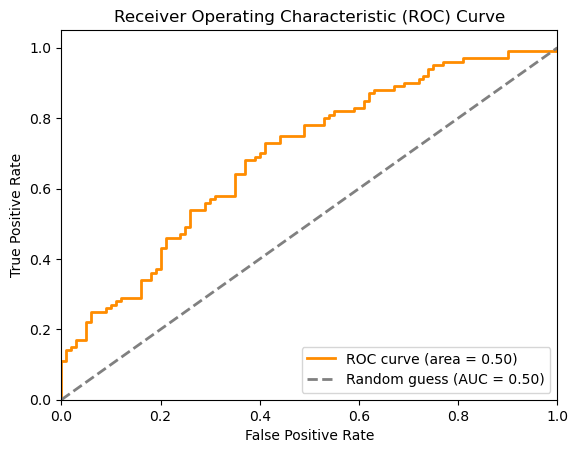

In [14]:
import matplotlib.pyplot as plt

Y = np.array([1, 2]*100)
X = np.random.uniform(size=[len(Y), 100])
n_iter = 1000
ansMat = np.full((len(Y), n_iter), np.nan)
for i in range(n_iter):
    train = np.random.choice(range(len(Y)), size=int(0.5*len(Y)), replace=False, p=None)
    if len(np.unique(Y)) == 1:
        continue
    test = np.array([i for i in range(len(Y)) if i not in train])
    mod = SVC(probability=False)
    mod.fit(X=X[train, :], y=Y[train])
    ansMat[test, i] = mod.predict(X[test, :])
ans = np.nanmean(ansMat, axis=1)
fpr, tpr, thresholds = roc_curve(Y, ans, pos_label=1)


print(auc(fpr, tpr))  

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Using StratifiedKFold to ensure balanced splits

AUC: 0.543


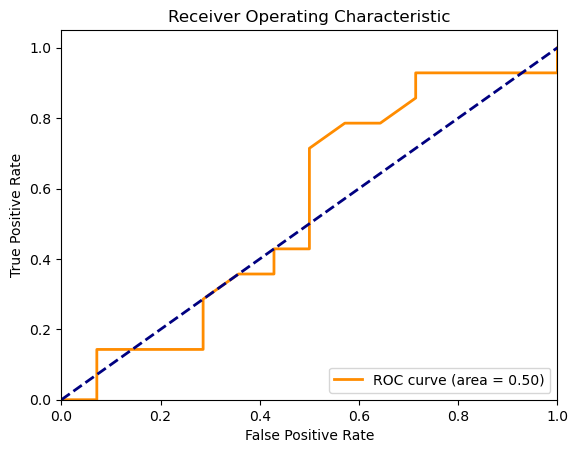

In [15]:

from sklearn.model_selection import StratifiedKFold

# Seed for reproducibility
np.random.seed(123)
Y = np.array([1, 2] * 14)  
X = np.random.uniform(size=[len(Y), 100]) 

n_iter = 1000
ansMat = np.full((len(Y), n_iter), np.nan)

skf = StratifiedKFold(n_splits=2)

for i in range(n_iter):
    for train_index, test_index in skf.split(X, Y):
        if len(np.unique(Y[train_index])) == 1:
            continue
            
        Y_shuffled = np.random.permutation(Y)

        mod = SVC(probability=False)
        mod.fit(X=X[train_index, :], y=Y_shuffled[train_index])
        ansMat[test_index, i] = mod.predict(X[test_index, :])
ans = np.nanmean(ansMat, axis=1)
fpr, tpr, thresholds = roc_curve(Y, ans, pos_label=1)
print(f"AUC: {auc(fpr, tpr):.3f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Adding noise

AUC: 0.500


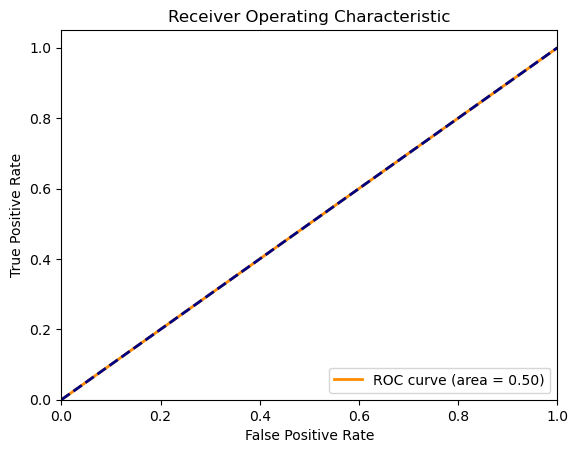

In [16]:

np.random.seed(20)

Y = np.array([1, 2] * 14)  
X = np.random.uniform(size=[len(Y), 100])  


noise = np.random.normal(0, 1, X.shape)
X += noise

n_iter = 100
ansMat = np.full((len(Y), n_iter), np.nan)

skf = StratifiedKFold(n_splits=2)

for i in range(n_iter):
    for train_index, test_index in skf.split(X, Y):
        if len(np.unique(Y[train_index])) == 1:
            continue
        
        Y_shuffled = np.random.permutation(Y)
        
        mod = SVC(probability=False)
        mod.fit(X[train_index, :], Y_shuffled[train_index])
        ansMat[test_index, i] = model.predict(X[test_index, :])

ans = np.nanmean(ansMat, axis=1)

fpr, tpr, thresholds = roc_curve(Y, ans, pos_label=1)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.3f}")




plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
